In [1]:
import torch
# import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR
# from snntorch import spikegen
# from sklearn.metrics import f1_score

from smogoutils import get_all_data_adj, compute_spiking_node_representation as csnr
from smogomodels import SMOGOGCN,SMOGOVCDN
from smogotrain import pretrain, smogotrain,smogotrain_v2, smogotest, smogotest_v2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ",device)

if device == "cuda":
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    torch.set_default_device("cuda")
else:
    torch.set_default_tensor_type(torch.FloatTensor)
    torch.set_default_device("cpu")

device:  cpu


/Users/gabriquaranta/repos/mla-prj-24-mla24-prj19-gu1/.env/lib/python3.9/site-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:433.)
  _C._set_default_tensor_type(t)


# Prepare data

In [3]:
data_folder = "BRCA"
view_list = [1, 2, 3]
num_view=3
num_class = 5

(
    data_tr_list,
    data_trte_list,
    trte_idx,
    labels_trte,
    labels_tr_tensor,
    onehot_labels_tr_tensor,
    adj_tr_list,
    adj_te_list,
    dim_list,
) = get_all_data_adj(
    data_folder,
    view_list,
    num_class,
)

/Users/gabriquaranta/repos/mla-prj-24-mla24-prj19-gu1/SMOGONET/smogoutils.py:120: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:623.)
  return sparse_tensortype(indices, values, x.size())


In [4]:
K = 3
num_steps = 100

enc_function = 'rate'
# enc_function = 'latency'

H_tr_v1 = csnr(data_tr_list[0], adj_tr_list[0], K, num_steps, enc_function).to(device)
H_tr_v2 = csnr(data_tr_list[1], adj_tr_list[1], K, num_steps, enc_function).to(device)
H_tr_v3 = csnr(data_tr_list[2], adj_tr_list[2], K, num_steps, enc_function).to(device)

H_trte_v1 = csnr(data_trte_list[0], adj_te_list[0], K, num_steps, enc_function).to(device)
H_trte_v2 = csnr(data_trte_list[1], adj_te_list[1], K, num_steps, enc_function).to(device)
H_trte_v3 = csnr(data_trte_list[2], adj_te_list[2], K, num_steps, enc_function).to(device)

H_te_v1=H_trte_v1 # only te part is extracted later
H_te_v2=H_trte_v2
H_te_v3=H_trte_v3

labels_tr=labels_tr_tensor.to(device)
labels_trte_tensor = torch.tensor(labels_trte).to(device)
labels_te=labels_trte_tensor[trte_idx['te']].to(device)

print(H_tr_v1.shape, H_tr_v2.shape, H_tr_v3.shape)
print(H_trte_v1.shape, H_trte_v2.shape, H_trte_v3.shape)
print(labels_tr.shape, labels_trte_tensor.shape, labels_te.shape)

torch.Size([100, 612, 1000]) torch.Size([100, 612, 1000]) torch.Size([100, 612, 503])
torch.Size([100, 875, 1000]) torch.Size([100, 875, 1000]) torch.Size([100, 875, 503])
torch.Size([612]) torch.Size([875]) torch.Size([263])


# Models

In [5]:
output_size = num_class

hidden_size1 = 50
hidden_size2 = 50
hidden_size3 = 50

beta1a=0.9
beta2a=0.9
beta3a=0.9

beta1b=0.9
beta2b=0.9
beta3b=0.9

sgcn1 = SMOGOGCN(H_tr_v1.shape[2], hidden_size1, output_size,beta1=beta1a,beta2=beta1b).to(device)
sgcn2 = SMOGOGCN(H_tr_v2.shape[2], hidden_size2, output_size,beta1=beta2a, beta2=beta2b).to(device)
sgcn3 = SMOGOGCN(H_tr_v3.shape[2], hidden_size3, output_size,beta1=beta3a, beta2=beta3b).to(device)

# sgcns output torch.stack(spk_rec), torch.stack(mem_rec)
# output spikes of shape for each: torch.Size([100, 875, 5])
# output probs of shape for each: torch.Size([875, 5])

# operations pre vcdn
# after outer product torch.Size([875, 125, 1])
# torch.Size([875, 125])
# torch.Size([100, 875, 125])

vcdn_input_size = 125
vcdn_hidden_size = 50
vcdn_beta1=0.9
vcdn_beta2=0.9

svcdn=SMOGOVCDN(vcdn_input_size, vcdn_hidden_size, output_size,beta1=vcdn_beta1,beta2=vcdn_beta2).to(device)

# Pretrain sgcns

In [6]:
# def pretrain(snn, inputs, targets, num_epoch_pretrain=10):
#     optimizer = optim.Adam(snn.parameters(), lr=0.01)
#     loss_fn = nn.CrossEntropyLoss()

#     for epoch in range(num_epoch_pretrain):
#         optimizer.zero_grad()
#         outputs, _ = snn(inputs)
#         outputs = outputs.mean(dim=0)  # average over time steps

#         loss = loss_fn(outputs, targets)
#         loss.backward()
#         optimizer.step()

#         if (epoch + 1) % 2 == 0:
#             print(f"Epoch {epoch + 1}/{num_epoch_pretrain}, Loss: {loss.item()}")
#     print()

In [7]:
num_epoch_pretrain1 = 100
num_epoch_pretrain2 = 100
num_epoch_pretrain3 = 100

lr1=0.1
lr2=0.1
lr3=0.1

losses1 = pretrain(sgcn1,H_tr_v1,labels_tr,num_epoch_pretrain1,lr=lr1)
losses2 = pretrain(sgcn3,H_tr_v3,labels_tr,num_epoch_pretrain2,lr=lr2)
losses3 = pretrain(sgcn2,H_tr_v2,labels_tr,num_epoch_pretrain3,lr=lr3)

Epoch 20/100, Loss: 1.0428324937820435
Epoch 40/100, Loss: 1.0207828283309937
Epoch 60/100, Loss: 1.001206874847412
Epoch 80/100, Loss: 0.9868412613868713
Epoch 100/100, Loss: 0.9820289611816406
Epoch 20/100, Loss: 1.0894440412521362
Epoch 40/100, Loss: 1.0403435230255127
Epoch 60/100, Loss: 1.0116885900497437
Epoch 80/100, Loss: 0.9935560822486877
Epoch 100/100, Loss: 0.9810560345649719
Epoch 20/100, Loss: 1.1045950651168823
Epoch 40/100, Loss: 1.0551906824111938
Epoch 60/100, Loss: 1.0213096141815186
Epoch 80/100, Loss: 0.994787871837616
Epoch 100/100, Loss: 0.9783267378807068


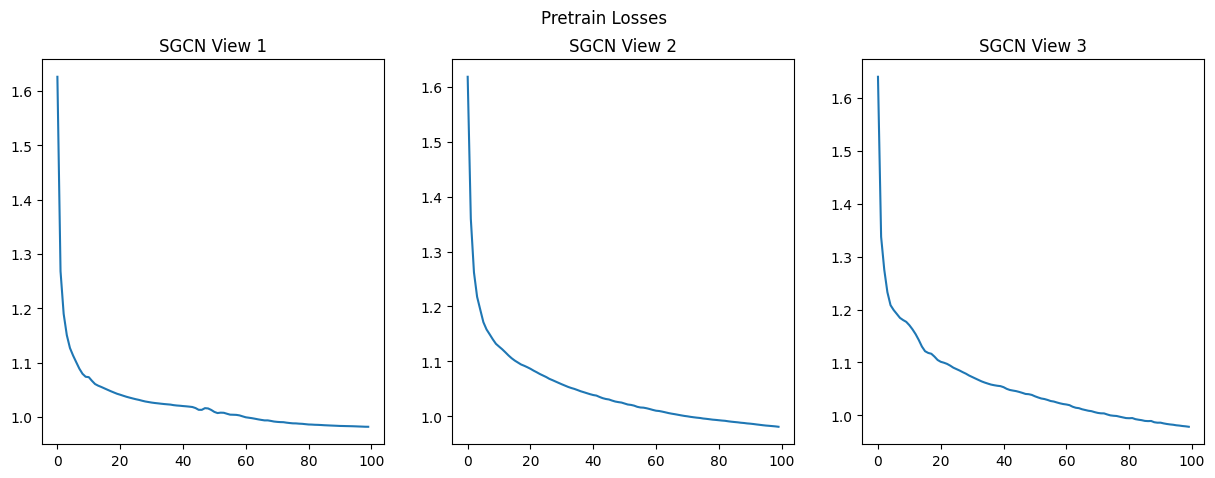

In [8]:
plt.figure(figsize=(15,5))
plt.suptitle("Pretrain Losses")
plt.subplot(1,3,1)
plt.plot(losses1)
plt.title('SGCN View 1')
plt.subplot(1,3,2)
plt.plot(losses2)
plt.title('SGCN View 2')
plt.subplot(1,3,3)
plt.plot(losses3)
plt.title('SGCN View 3')
plt.show()

# Train Jointly

In [9]:
num_epochs = 500

snns = [sgcn1, sgcn2, sgcn3, svcdn]

H_trs = [H_tr_v1, H_tr_v2, H_tr_v3]

lr1 = 0.01
lr2 = 0.01
lr3 = 0.01
lr4 = 0.1 # .1 better start than .01

step_size1 = 10
step_size2 = 10
step_size3 = 10
step_size4 = 10

gamma1 = 0.5
gamma2 = 0.5
gamma3 = 0.5
gamma4 = 0.5

optimizer1 = optim.Adam(sgcn1.parameters(), lr=lr1)
optimizer2 = optim.Adam(sgcn2.parameters(), lr=lr2)
optimizer3 = optim.Adam(sgcn3.parameters(), lr=lr3)
optimizer4 = optim.Adam(svcdn.parameters(), lr=lr4)

scheduler1 = StepLR(optimizer1, step_size=step_size1, gamma=gamma1)
scheduler2 = StepLR(optimizer2, step_size=step_size2, gamma=gamma2)
scheduler3 = StepLR(optimizer3, step_size=step_size3, gamma=gamma3)
scheduler4 = StepLR(optimizer4, step_size=step_size4, gamma=gamma4)

opt_list=[optimizer1,optimizer2,optimizer3,optimizer4]
sched_list=[scheduler1,scheduler2,scheduler3,scheduler4]

# losses = smogotrain(
#     snns,
#     H_trs,
#     labels_tr,
#     opt_list=opt_list,
#     sched_list=sched_list,
#     num_epochs=num_epochs,
#     l2_lambda=0.0001, # set to 0 to not use regularization
# )
losses = smogotrain_v2(
    snns,
    H_trs,
    labels_tr,
    opt_list=opt_list,
    sched_list=sched_list,
    num_epochs=num_epochs,
    l2_lambda=0.0001, # set to 0 to not use regularization
)

Epoch 1/500, Loss: 1.89860200881958
Epoch 11/500, Loss: 0.9937250018119812
Epoch 21/500, Loss: 0.9870954751968384
Epoch 31/500, Loss: 0.983964204788208
Epoch 41/500, Loss: 0.9828042387962341
Epoch 51/500, Loss: 0.9818798899650574
Converged at epoch 51, Loss = 0.9818123579025269


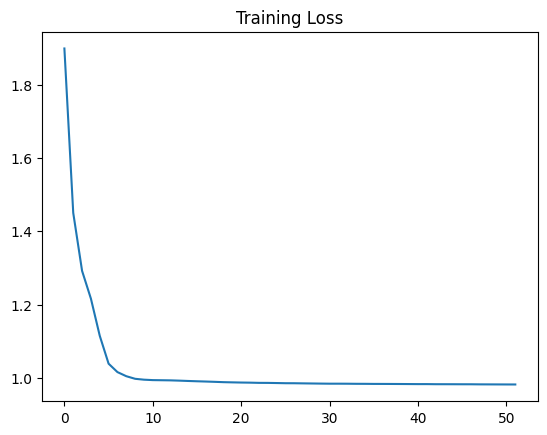

In [10]:
plt.title("Training Loss")
plt.plot(losses)

In [11]:
# optimizer1 = optim.Adam(sgcn1.parameters(), lr=0.01)
# optimizer2 = optim.Adam(sgcn2.parameters(), lr=0.01)
# optimizer3 = optim.Adam(sgcn3.parameters(), lr=0.01)
# optimizer4 = optim.Adam(svcdn.parameters(), lr=0.001)

# scheduler1 = StepLR(optimizer1, step_size=10, gamma=0.5)
# scheduler2 = StepLR(optimizer2, step_size=10, gamma=0.5)
# scheduler3 = StepLR(optimizer3, step_size=10, gamma=0.5)
# scheduler4 = StepLR(optimizer4, step_size=10, gamma=0.5)

# loss_fn = nn.CrossEntropyLoss()
# losses=[]

# for epoch in range(num_epochs):
#     optimizer1.zero_grad()
#     optimizer2.zero_grad()
#     optimizer3.zero_grad()
#     optimizer4.zero_grad()

#     outputs1, _ = sgcn1(H_tr_v1)
#     outputs2, _ = sgcn2(H_tr_v2)
#     outputs3, _ = sgcn3(H_tr_v3)

#     outputs1 = outputs1.mean(dim=0)
#     outputs2 = outputs2.mean(dim=0)
#     outputs3 = outputs3.mean(dim=0)

#     in_list=[outputs1, outputs2, outputs3]

#     for i in range(num_view):
#         in_list[i] = torch.sigmoid(in_list[i])


#     x = torch.reshape(
#         torch.matmul(in_list[0].unsqueeze(-1), in_list[1].unsqueeze(1)),
#         (-1, pow(num_class, 2), 1),
#     )
#     x = torch.reshape(
#         torch.matmul(x, in_list[2].unsqueeze(1)),
#         (-1, pow(num_class, 3), 1),
#     )

#     vcdn_feat = torch.reshape(x, (-1, pow(num_class, num_view)))

#     vcdn_input_spike_encoding= spikegen.rate(vcdn_feat,100)

#     outputs4, _ = svcdn(vcdn_input_spike_encoding)

#     outputs4 = outputs4.mean(dim=0)

#     loss = loss_fn(outputs4, labels_tr)
#     losses.append(loss.item())
#     loss.backward()

#     optimizer1.step()
#     optimizer2.step()
#     optimizer3.step()
#     optimizer4.step()

#     scheduler1.step()
#     scheduler2.step()
#     scheduler3.step()
#     scheduler4.step()

#     if (epoch + 1) % 10 == 0:
#         print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')


# Test

In [12]:
# load = True
load = False

if load:
    sgcn1=SMOGOGCN(H_te_v1.shape[2], hidden_size1, output_size)
    sgcn2=SMOGOGCN(H_te_v2.shape[2], hidden_size2, output_size)
    sgcn3=SMOGOGCN(H_te_v3.shape[2], hidden_size3, output_size)
    svcdn=SMOGOVCDN(vcdn_input_size, vcdn_hidden_size, output_size)

    sgcn1.load_state_dict(torch.load('models/sgcn1.pth'))
    sgcn2.load_state_dict(torch.load('models/sgcn2.pth'))
    sgcn3.load_state_dict(torch.load('models/sgcn3.pth'))
    svcdn.load_state_dict(torch.load('models/svcdn.pth'))

In [13]:
idx_te = trte_idx['te']

snn_list = [sgcn1, sgcn2, sgcn3, svcdn]
H_te_list = [H_te_v1, H_te_v2, H_te_v3]

# a = smogotest(snn_list, H_te_list, labels_trte_tensor, labels_te, idx_te)
a = smogotest_v2(snn_list, H_te_list, labels_trte_tensor, labels_te, idx_te)

Over 10 test runs:
- Accuracy on train+test set  : 0.8537142857142859
- Accuracy on test set        : 0.8403041825095057
- F1 on test set              : 0.8436331283875074
- F1 macro on test set        : 0.8020338357944257


In [14]:
# outputs1, _ = sgcn1(H_te_v1)
# outputs2, _ = sgcn2(H_te_v2)
# outputs3, _ = sgcn3(H_te_v3)

# outputs1 = outputs1.mean(dim=0)
# outputs2 = outputs2.mean(dim=0)
# outputs3 = outputs3.mean(dim=0)

# in_list=[outputs1, outputs2, outputs3]

# accuracies_trte = []
# accuracies_te = []
# f1s_te = []
# f1s_te_macro = []

# num_tests = 10

# for i in range(num_view):
#     in_list[i] = torch.sigmoid(in_list[i])


# x = torch.reshape(
#     torch.matmul(in_list[0].unsqueeze(-1), in_list[1].unsqueeze(1)),
#     (-1, pow(num_class, 2), 1),
# )
# x = torch.reshape(
#     torch.matmul(x, in_list[2].unsqueeze(1)),
#     (-1, pow(num_class, 3)),
# )

# vcdn_input_spike_encoding = spikegen.rate(x,100)

# for i in range(num_tests):

#     outputs4, _ = svcdn(vcdn_input_spike_encoding)

#     accuracy=(torch.argmax(outputs4.mean(dim=0), dim=1) == labels_trte_tensor).sum().item() / labels_trte_tensor.size(0)
#     accuracies_trte.append(accuracy)

#     accuracy_te=(torch.argmax(outputs4.mean(dim=0)[idx_te], dim=1) == labels_te).sum().item() / labels_te.size(0)
#     accuracies_te.append(accuracy_te)

#     f1_te = f1_score(labels_te, torch.argmax(outputs4.mean(dim=0)[idx_te], dim=1), average='weighted')
#     f1s_te.append(f1_te)

#     f1_te = f1_score(labels_te, torch.argmax(outputs4.mean(dim=0)[idx_te], dim=1), average='macro')
#     f1s_te_macro.append(f1_te)

# print(f"Over 10 test runs:")
# # print(f'- Accuracy on train+test set  : {sum(accuracies_trte) / num_tests}')
# print(f'- Accuracy on test set        : {sum(accuracies_te) / num_tests}')
# print(f'- F1 on test set              : {sum(f1s_te) / num_tests}')
# print(f'- F1 macro on test set        : {sum(f1s_te_macro) / num_tests}')


In [16]:
save = True
save = False

if save:
    torch.save(sgcn1.state_dict(), 'models/sgcn1.pth')
    torch.save(sgcn2.state_dict(), 'models/sgcn2.pth')
    torch.save(sgcn3.state_dict(), 'models/sgcn3.pth')
    torch.save(svcdn.state_dict(), 'models/svcdn.pth')